In [18]:
"""
CoastScout Explorer

Python tools for playing with CoastScout buoy data
Focus on buoy-buoy comparsion with CDIP 201 "Scripps Nearshore" off La Jolla, CA

Contact: Bryan Murray, bryan@calwave.energy

Change Log:
    + 8/28/2020: First commit

"""

'\nCoastScout Explorer\n\nPython tools for playing with CoastScout buoy data\nFocus on buoy-buoy comparsion with CDIP 201 "Scripps Nearshore" off La Jolla, CA\n\nContact: Bryan Murray, bryan@calwave.energy\n\nChange Log:\n    + 8/28/2020: First commit\n\n'

In [19]:
import pandas as pd
import numpy as np
import datetime
import netCDF4
import time
import calendar
import matplotlib.pyplot as plt
%matplotlib notebook

In [20]:
def iso2posix(iso_timestamp):
    '''Convert CoastScout's ISO-formated date strings to datetime, then posix timestamp'''
    import datetime
    dt = datetime.datetime.fromisoformat(iso_timestamp)
    return dt.timestamp()

In [21]:
# Import CoastScout Data
# CS "report_time" field is in UTC

def report_timestamp2datetime(report_timestamp):
    import datetime
    fmt = '%Y-%m-%dT%H:%M:%S+00:00'
    return datetime.datetime.strptime(report_timestamp,fmt)

p2csdata = r'Scripps02_FebAug2020.csv'
cs = pd.read_csv(p2csdata,
                  parse_dates=[2],
                  date_parser=report_timestamp2datetime)

# create "tepoch" column to hold posix time stamps
cs['tepoch'] = cs.report_timestamp.apply(lambda dt: int(dt.timestamp()))

In [22]:
# Open local copy of CDIP201 netCDF "real-time" file
# it happens to cover February - August 2020
p2CDIP201_rt = r'201p1_rt_FebAug2020.nc'
ds = netCDF4.Dataset(p2CDIP201_rt)
ds.set_always_mask(False)

# Create pandas DataFrame for CDIP201
dsTime = ds.variables['waveTime'][:]
timeall = [datetime.datetime.fromtimestamp(t) for t in dsTime] # Convert ncTime variable to datetime stamps
Hs = ds.variables['waveHs'][:]
Tp = ds.variables['waveTp'][:]
Dp = ds.variables['waveDp'][:] 

data = {'t':dsTime,'dt':timeall,'Hs':Hs,'Tp':Tp,'Dp':Dp}
cdip201 = pd.DataFrame(data)
cdip201 = cdip201.set_index('t')

In [23]:
# To align Scripps02 and CDIP201, we'll create a column holding posix time stamps
# we can then use the timestamps for a join

# First the CoastScout buoy
cs['thh'] = cs.tepoch
cs.thh= cs.thh.apply(lambda ti: ti - (ti%1800)) 
cs = cs.set_index('thh')

# round buoy 201 'nearshore' down to half-hour
cdip201['thh'] = cdip201.index
cdip201.thh= cdip201.thh.apply(lambda ti: ti - (ti%1800))
cdip201 = cdip201.set_index('thh')

df = pd.merge(cdip201,cs,left_index=False,right_index=True,how='inner',on=['thh','thh']) #<-- returns empty
df.dropna(inplace=True)
df['dt'] = df.tepoch.apply(lambda thh: datetime.datetime.fromtimestamp(thh))
#df.to_csv(r'path\cdip_cs.csv')

In [24]:
# Time Series Compendium
# Time series of wave height, peak wave periods, and mean wave direction
f1, (pHs,pTp,pDp) = plt.subplots(3,1,sharex=True,figsize=(15,10),num='CDIP201 vs CoastScout, Feb-Aug 2020')

# Set title
plt.suptitle('CDIP201 vs CoastScout, Feb-Aug 2020',fontsize=22)

# Create 3 stacked subplots for three parameters: (Hs,Tp,Dp)
pHs.plot(df.dt,df.Hs,'b-')
pHs.plot(df.dt,df.wave_significant_height_m,'g-')
pHs.legend(['CDIP201','Scripps02'],fontsize=14,loc='upper right')
pHs.set_ylabel('Hs, m',fontsize=18)
pHs.set_ylim(0,3)
pHs.set_yticks([0,1.,2.,3.])
pHs.grid(b=True, which='major', color='dimgrey', linestyle='--')

pTp.plot(df.dt,df.Tp,'b-')
pTp.plot(df.dt,df.wave_peak_period_seconds,'g-')
pTp.legend(['CDIP201','Scripps02'],fontsize=14,loc='upper right')
pTp.set_ylabel('Tp, sec',fontsize=18)
pTp.set_ylim(2,22)
pTp.set_yticks([4,8,12,16,20])
pTp.grid(b=True, which='major', color='dimgrey', linestyle='--')

pDp.plot(df.dt,df.Dp,'b-')
pDp.plot(df.dt,df.wave_mean_direction_degrees,'g-')
pDp.legend(['CDIP201','Scripps02'],fontsize=14,loc='upper right')
pDp.set_ylabel('Dp, degrees', fontsize=18) 
pDp.set_ylim(180,360)
pDp.set_yticks([180,225,270,315,360])
pDp.grid(b=True, which='major', color='dimgrey', linestyle='--')


<IPython.core.display.Javascript object>


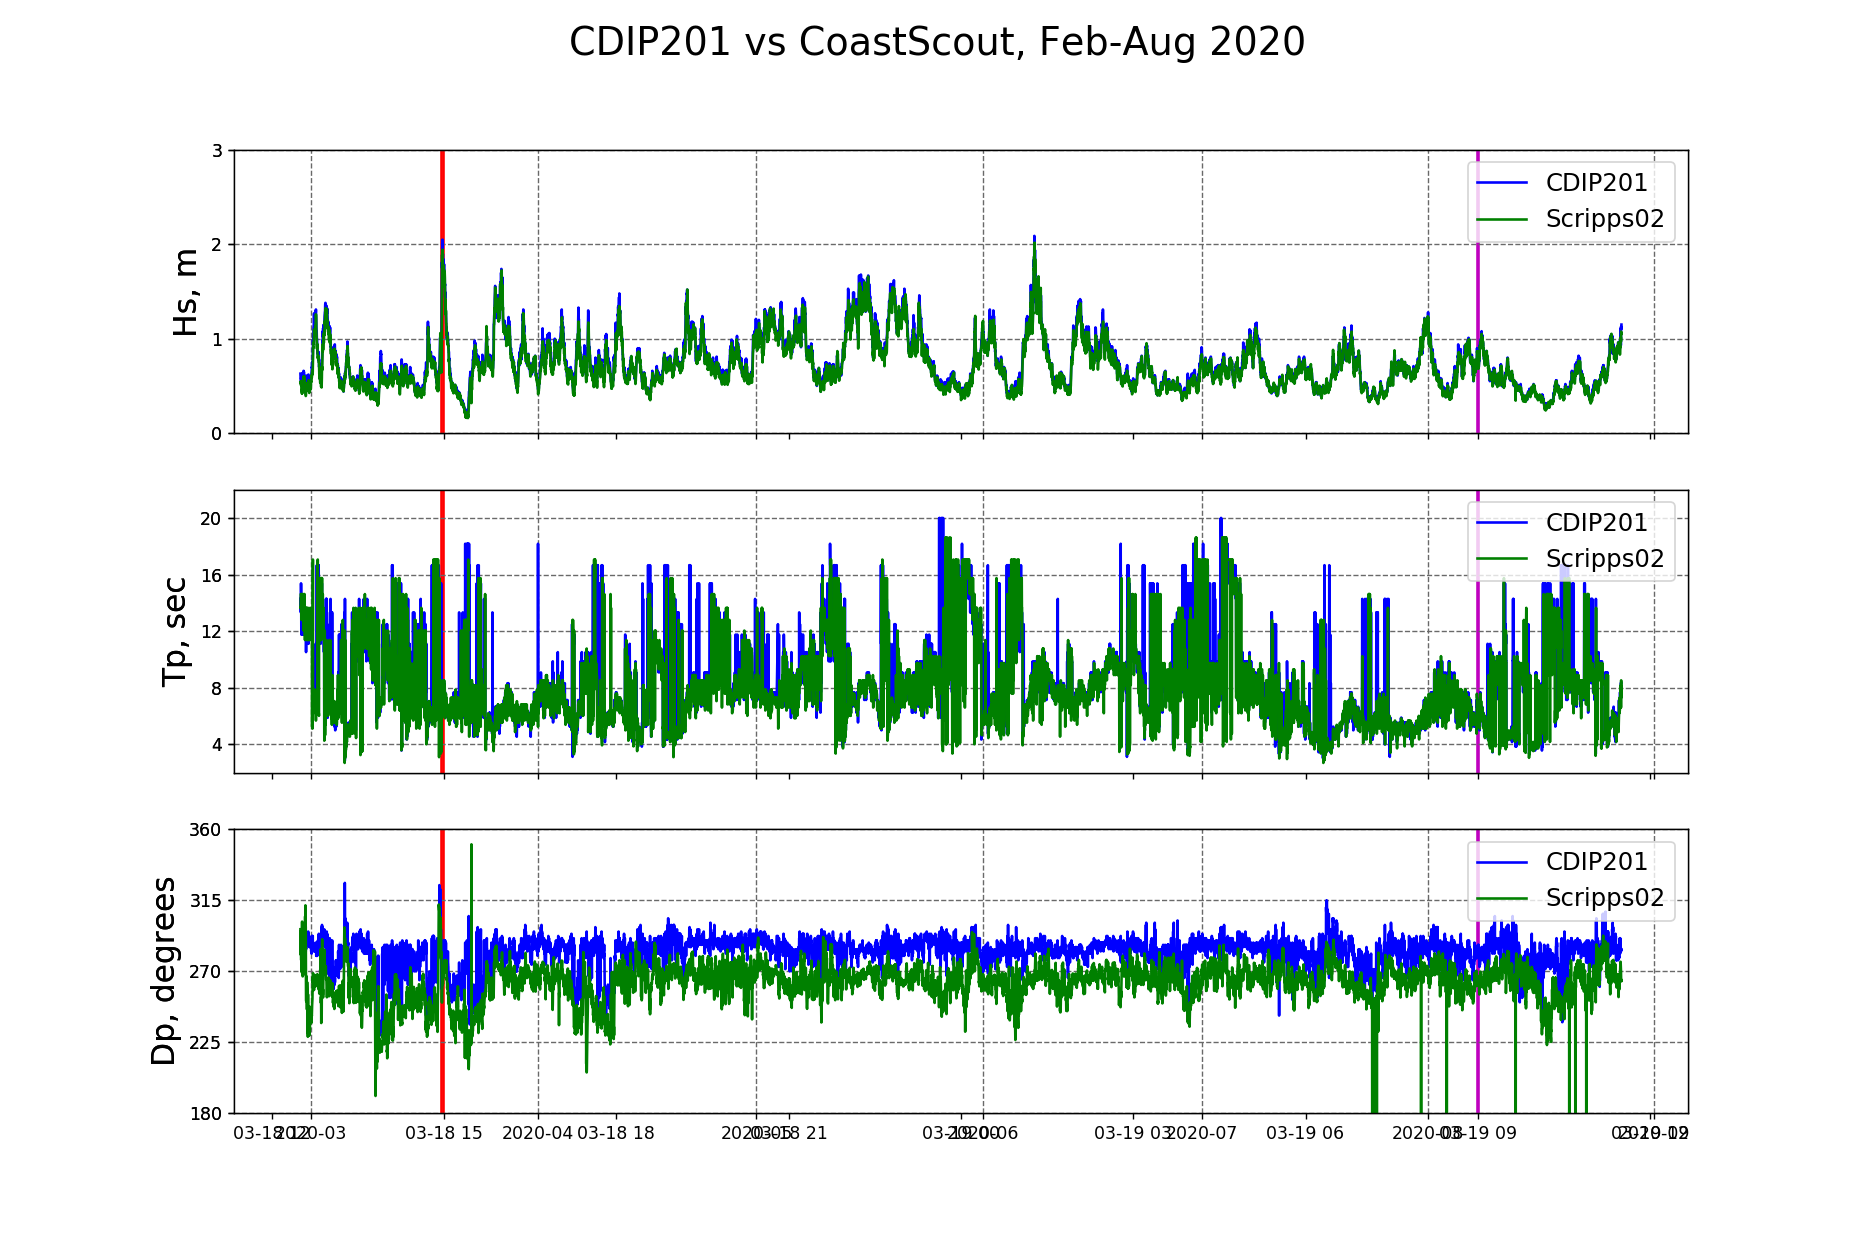

In [25]:
# Looking at the interesting periods, we can choose some interesting times to plot in our compendium
# For instance, a gnarly storm came up circa March 18

start_date = datetime.datetime(2020,3,18,12,0,0)
end_date = datetime.datetime(2020,3,19,12,0,0)
mask = (df.dt>start_date) & (df.dt<end_date)

f2, (pHs,pTp,pDp) = plt.subplots(3,1,sharex=True,figsize=(10,6),num='CDIP201 vs CoastScout, Feb-Aug 2020')

# Set title
plt.suptitle('CDIP201 vs CoastScout, storm event circa March 18-19',fontsize=12)

# Create 3 stacked subplots for three parameters: (Hs,Tp,Dp)
pHs.plot(df.dt.loc[mask],df.Hs.loc[mask],'b-')
pHs.plot(df.dt.loc[mask],df.wave_significant_height_m.loc[mask],'g-')
pHs.legend(['CDIP201','Scripps02'],fontsize=14,loc='upper right')
pHs.set_ylabel('Hs, m',fontsize=18)
pHs.set_ylim(0,3)
pHs.set_yticks([0,1.,2.,3.])
pHs.grid(b=True, which='major', color='dimgrey', linestyle='--')

pTp.plot(df.dt.loc[mask],df.Tp.loc[mask],'b-')
pTp.plot(df.dt.loc[mask],df.wave_peak_period_seconds.loc[mask],'g-')
pTp.legend(['CDIP201','Scripps02'],fontsize=14,loc='upper right')
pTp.set_ylabel('Tp, sec',fontsize=18)
pTp.set_ylim(2,22)
pTp.set_yticks([4,8,12,16,20])
pTp.grid(b=True, which='major', color='dimgrey', linestyle='--')

pDp.plot(df.dt.loc[mask],df.Dp.loc[mask],'b-')
pDp.plot(df.dt.loc[mask],df.wave_mean_direction_degrees.loc[mask],'g-')
pDp.legend(['CDIP201','Scripps02'],fontsize=14,loc='upper right')
pDp.set_ylabel('Dp, degrees', fontsize=18) 
pDp.set_ylim(180,360)
pDp.set_yticks([180,225,270,315,360])
pDp.grid(b=True, which='major', color='dimgrey', linestyle='--')

In [26]:
# We should also find a good example of the PacWave Bullseye case
# PacWave Bulleye
pac = df[(df.Hs>.65) & (df.Hs<.85) & (df.Tp>5.25) & (df.Tp<5.75)]
pac.iloc[-20:,:] # look at the last 20 samples

,dt,Hs,Tp,Dp,latitude,longitude,report_timestamp,wave_max_height_m,wave_mean_direction_degrees,wave_peak_period_seconds,wave_significant_height_m,wind_direction_degrees,wind_gust_10m_kn,wind_gust_kn,wind_speed_10m_kn,wind_speed_kn,wind_temperature_c,tepoch
thh,,,,,,,,,,,,,,,,,,
1596823200,2020-08-07 11:00:00,0.71,5.555555,281.00000,32.867002,-117.263756,2020-08-07 18:00:00,1.224121,259.154766,5.688889,0.778499,297.782462,6.241864,5.0,4.989195,3.996558,23.000000,1596823200
1596825000,2020-08-07 11:30:00,0.69,5.555555,286.62500,32.867005,-117.263732,2020-08-07 18:30:00,1.570577,261.936103,5.851429,0.723940,278.138299,7.365400,5.9,6.309736,5.054368,23.144231,1596825000
1596826800,2020-08-07 12:00:00,0.70,5.555555,283.81250,32.867002,-117.263709,2020-08-07 19:00:00,1.339867,263.879412,5.389474,0.729986,265.422530,8.114424,6.5,6.678231,5.349548,23.557692,1596826800
1596828600,2020-08-07 12:30:00,0.71,5.555555,279.59375,32.867073,-117.263606,2020-08-07 19:30:00,1.157389,265.745017,5.688889,0.723009,267.303533,8.239261,6.6,5.691447,4.559092,24.000000,1596828600
1596830400,2020-08-07 13:00:00,0.70,5.263158,285.21875,32.867107,-117.263588,2020-08-07 20:00:00,1.154072,267.389922,5.688889,0.697807,259.161766,8.738610,7.0,7.794752,6.243929,24.000000,1596830400
1596832200,2020-08-07 13:30:00,0.70,5.555555,279.59375,32.867291,-117.263525,2020-08-07 20:30:00,1.056432,267.241432,5.851429,0.645690,268.980216,10.736007,8.6,8.868524,7.104067,24.000000,1596832200
1596834000,2020-08-07 14:00:00,0.73,5.555555,282.40625,32.867292,-117.263635,2020-08-07 21:00:00,1.050035,262.854078,5.389474,0.681398,271.465530,11.485030,9.2,9.697103,7.767793,24.000000,1596834000
1596835800,2020-08-07 14:30:00,0.70,5.263158,285.21875,32.867205,-117.263560,2020-08-07 21:30:00,1.341963,262.976075,5.535135,0.719859,270.709984,10.361495,8.3,9.456900,7.575380,23.490385,1596835800
1596837600,2020-08-07 15:00:00,0.70,5.555555,281.00000,32.867166,-117.263527,2020-08-07 22:00:00,1.214498,266.623210,5.535135,0.724557,270.192182,11.984380,9.6,10.350128,8.290895,23.278846,1596837600


In [27]:
# Dear MarineLab engineers, we'd like full-resultion data for these times:
print(datetime.datetime(2020,3,18,18,0,0).timestamp()) # Storm start
print(datetime.datetime(2020,3,19,0,0,0).timestamp())  # storm end
print(datetime.datetime(2020,8,7,18,0,0).timestamp())  # PacWave start
print(datetime.datetime(2020,8,7,22,30,0).timestamp()) # PacWave end

1584579600.0
1584601200.0
1596848400.0
1596864600.0


In [28]:
# Time Series Compendium, with periods of interest 
f3, (pHs,pTp,pDp) = plt.subplots(3,1,sharex=True,figsize=(10,6),num='CDIP201 vs CoastScout, Feb-Aug 2020')

# Set title
plt.suptitle('CDIP201 vs CoastScout, Feb-Aug 2020',fontsize=12)

# Create 3 stacked subplots for three parameters: (Hs,Tp,Dp)
pHs.plot(df.dt,df.Hs,'b-')
pHs.plot(df.dt,df.wave_significant_height_m,'g-')
pHs.legend(['CDIP201','Scripps02'],fontsize=14,loc='upper right')
pHs.set_ylabel('Hs, m',fontsize=18)
pHs.set_ylim(0,3)
pHs.set_yticks([0,1.,2.,3.])
pHs.grid(b=True, which='major', color='dimgrey', linestyle='--')
pHs.axvline(x=datetime.datetime(2020,3,18,18,0,0),c='r',zorder=1) # Start of March 18 storm
pHs.axvline(x=datetime.datetime(2020,3,19,0,0,0),c='r',zorder=1) 
pHs.axvline(x=datetime.datetime(2020,8,7,18,0,0),c='m',zorder=1)  # Aug. 7th IWS2
pHs.axvline(x=datetime.datetime(2020,8,7,22,30,0),c='m',zorder=1)

pTp.plot(df.dt,df.Tp,'b-')
pTp.plot(df.dt,df.wave_peak_period_seconds,'g-')
pTp.legend(['CDIP201','Scripps02'],fontsize=14,loc='upper right')
pTp.set_ylabel('Tp, sec',fontsize=18)
pTp.set_ylim(2,22)
pTp.set_yticks([4,8,12,16,20])
pTp.grid(b=True, which='major', color='dimgrey', linestyle='--')
pTp.axvline(x=datetime.datetime(2020,3,18,18,0,0),c='r',zorder=1) # Start of March 18 storm
pTp.axvline(x=datetime.datetime(2020,3,19,0,0,0),c='r',zorder=1) 
pTp.axvline(x=datetime.datetime(2020,8,7,18,0,0),c='m',zorder=1)  # Aug. 7th IWS2
pTp.axvline(x=datetime.datetime(2020,8,7,22,30,0),c='m',zorder=1)

pDp.plot(df.dt,df.Dp,'b-')
pDp.plot(df.dt,df.wave_mean_direction_degrees,'g-')
pDp.legend(['CDIP201','Scripps02'],fontsize=14,loc='upper right')
pDp.set_ylabel('Dp, degrees', fontsize=18) 
pDp.set_ylim(180,360)
pDp.set_yticks([180,225,270,315,360])
pDp.grid(b=True, which='major', color='dimgrey', linestyle='--')
pDp.axvline(x=datetime.datetime(2020,3,18,18,0,0),c='r',zorder=1) # Start of March 18 storm
pDp.axvline(x=datetime.datetime(2020,3,19,0,0,0),c='r',zorder=1) 
pDp.axvline(x=datetime.datetime(2020,8,7,18,0,0),c='m',zorder=1)  # Aug. 7th IWS2
pDp.axvline(x=datetime.datetime(2020,8,7,22,30,0),c='m',zorder=1)